In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Tofaş.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop(df2[(df2["Fiyat"] > 500000)].index, axis=0, inplace=True)

In [4]:
df2.drop(df2[(df2["Fiyat"] < 60000)].index, axis=0, inplace=True)

In [5]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [6]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Doğan,Seri_Kartal,Seri_Murat,...,Model_Kartal 5 Vites,Model_L,Model_S,Model_SL,Model_SLX,Model_SLX ie,Model_Şahin 5 Vites,Yakıt Tipi_Benzin,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz
0,125000,2000,83,1581,70000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,105000,1996,83,1581,150000,NaN,NaN,0,1,0,...,1,0,0,0,0,0,0,0,1,1
2,170000,1994,51,1581,189000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,240000,1998,96,1581,97546,NaN,NaN,1,0,0,...,0,0,0,0,0,1,0,0,1,1
4,168000,1993,83,1581,99000,9.0,3.0,1,0,0,...,0,0,0,0,1,0,0,0,1,1


In [7]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [10]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [11]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_18308\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,35486.774388,1.132092e+09,33646.581804,25391.555894


In [12]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:24:39,071] A new study created in memory with name: no-name-f46b04a9-959a-431f-8e7e-4aaf107fe923
[I 2023-10-08 14:24:39,159] Trial 3 finished with value: 33409.12028950601 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.42072015921650524, 'max_depth': 7, 'min_child_weight': 183}. Best is trial 3 with value: 33409.12028950601.
[I 2023-10-08 14:24:39,159] Trial 0 finished with value: 128668.9642818641 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.007341298477535498, 'max_depth': 14, 'min_child_weight': 185}. Best is trial 3 with value: 33409.12028950601.
[I 2023-10-08 14:24:39,159] Trial 2 finished with value: 130631.75396722755 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.005550754843032027, 'max_depth': 8, 'min_child_weight': 245}. Best is trial 3 with value: 33409.12028950601.
[I 2023-10-08 14:24:39,172] Trial 7 finished with value: 121278.70502413568 and parameters: {'co

[I 2023-10-08 14:24:39,993] Trial 31 finished with value: 37696.62636585708 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.17647685548163533, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:39,993] Trial 29 finished with value: 37729.62572354191 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1762359682543943, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:40,043] Trial 32 finished with value: 36767.1521773904 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.17361824046298122, 'max_depth': 5, 'min_child_weight': 34}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:40,119] Trial 33 finished with value: 43942.17354115144 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1443995755733022, 'max_depth': 3, 'min_child_weight': 5

[I 2023-10-08 14:24:41,130] Trial 58 finished with value: 31464.165804291544 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.49406981411281314, 'max_depth': 11, 'min_child_weight': 109}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:41,199] Trial 61 finished with value: 31367.48907251997 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.4880293449854954, 'max_depth': 11, 'min_child_weight': 113}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:41,229] Trial 62 finished with value: 31805.70627998851 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.49596576360575273, 'max_depth': 11, 'min_child_weight': 112}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:41,232] Trial 63 finished with value: 31728.217929464987 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.47083359343297543, 'max_depth': 12, 'min_child

[I 2023-10-08 14:24:42,454] Trial 90 finished with value: 31236.56266721279 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.401112626832789, 'max_depth': 8, 'min_child_weight': 136}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:42,502] Trial 92 finished with value: 39266.17524300528 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.392499642990522, 'max_depth': 8, 'min_child_weight': 257}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:42,502] Trial 91 finished with value: 31200.810461716934 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.3913383459555681, 'max_depth': 8, 'min_child_weight': 122}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:42,598] Trial 94 finished with value: 30520.127100089736 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3980610533487782, 'max_depth': 7, 'min_child_weight':

[I 2023-10-08 14:24:43,785] Trial 119 finished with value: 30545.205770986566 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4255880977127244, 'max_depth': 5, 'min_child_weight': 85}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:43,905] Trial 122 finished with value: 30513.85028271269 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4379015220563105, 'max_depth': 5, 'min_child_weight': 68}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:43,976] Trial 121 finished with value: 30378.31856209048 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4445850953881594, 'max_depth': 5, 'min_child_weight': 65}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:44,022] Trial 124 finished with value: 30232.098659400534 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4644977860859075, 'max_depth': 6, 'min_child_weigh

[I 2023-10-08 14:24:45,364] Trial 151 finished with value: 30151.134540328396 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.38221733082431675, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:45,364] Trial 150 finished with value: 31414.022697924433 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.4906192860295038, 'max_depth': 13, 'min_child_weight': 12}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:45,420] Trial 152 finished with value: 29812.792552931583 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.3745902434030877, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:45,584] Trial 153 finished with value: 29947.871289754177 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.37637403236182887, 'max_depth': 5, 'min_child_

[I 2023-10-08 14:24:46,903] Trial 178 finished with value: 31175.61545873147 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.3057431532572592, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:47,084] Trial 182 finished with value: 132244.13763286386 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.004222377305446295, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:47,100] Trial 181 finished with value: 30478.680471547712 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.3850111314751429, 'max_depth': 15, 'min_child_weight': 24}. Best is trial 24 with value: 29534.635959544008.
[I 2023-10-08 14:24:47,132] Trial 184 finished with value: 30280.59791805124 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.38008402051808193, 'max_depth': 15, 'min_child_

[I 2023-10-08 14:24:48,618] Trial 209 finished with value: 31005.43986583292 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.25688988403526686, 'max_depth': 14, 'min_child_weight': 20}. Best is trial 183 with value: 29287.422827524246.
[I 2023-10-08 14:24:48,750] Trial 211 finished with value: 30675.389332415016 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.27066938012797775, 'max_depth': 14, 'min_child_weight': 22}. Best is trial 183 with value: 29287.422827524246.
[I 2023-10-08 14:24:48,757] Trial 212 finished with value: 30658.682330935448 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.26956159743698827, 'max_depth': 14, 'min_child_weight': 21}. Best is trial 183 with value: 29287.422827524246.
[I 2023-10-08 14:24:48,938] Trial 215 finished with value: 65816.24313373186 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.08187450167439057, 'max_depth': 12, 'min_

[I 2023-10-08 14:24:50,697] Trial 240 finished with value: 56154.73670973227 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.10338240480985159, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 183 with value: 29287.422827524246.
[I 2023-10-08 14:24:50,784] Trial 241 finished with value: 29732.688776967163 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4125058503680016, 'max_depth': 3, 'min_child_weight': 26}. Best is trial 183 with value: 29287.422827524246.
[I 2023-10-08 14:24:50,939] Trial 242 finished with value: 29788.970417172837 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3841804018883683, 'max_depth': 3, 'min_child_weight': 27}. Best is trial 183 with value: 29287.422827524246.
[I 2023-10-08 14:24:50,952] Trial 243 finished with value: 114944.92771641111 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01956193509497208, 'max_depth': 3, 'min_child

In [14]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 29287.4228
Best params:
	colsample_bytree: 0.4
	subsample: 0.5
	learning_rate: 0.3793048789303307
	max_depth: 15
	min_child_weight: 7


In [15]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 37466.167257092995, 'MSE': 1168503269.7887123, 'RMSE': 34183.37709748281, 'MAE': 25983.666026659605}


In [16]:
r2 = r2_score(y_test, y_pred)
r2

0.2332310534444676

In [17]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.21548763980516605

In [18]:
marka_model = joblib.dump(final_model, "Tofaş.pkl")

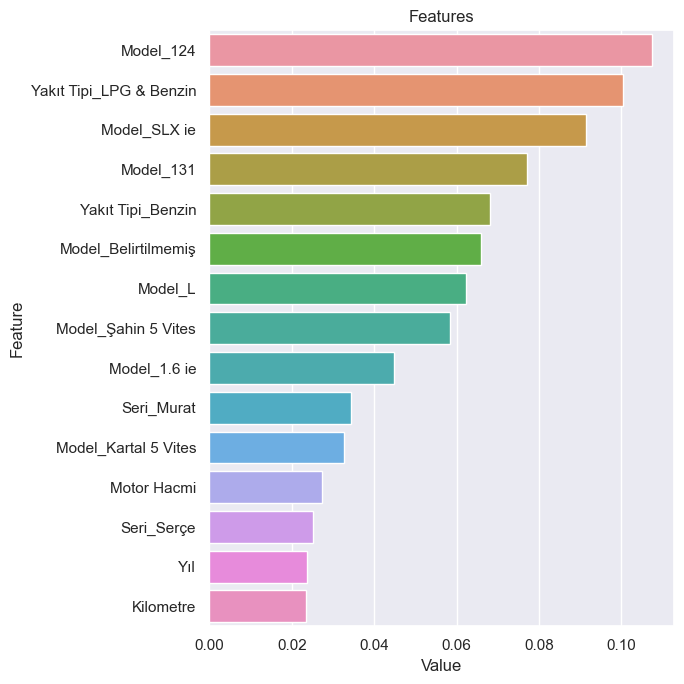

In [19]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)

In [20]:
df2.shape

(1770, 29)

In [21]:
y_test2 = list(y_test)

In [22]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [23]:
df3.head(15)

,test,pred,fark
0,70000,90572.992188,20572.992188
1,150000,103583.648438,-46416.351562
2,167000,161818.781250,-5181.218750
3,130000,118464.250000,-11535.750000
4,79500,108364.710938,28864.710938
5,155000,102718.148438,-52281.851562
6,112000,136043.375000,24043.375000
7,187500,162391.984375,-25108.015625
8,113000,55713.585938,-57286.414062
9,135000,206209.796875,71209.796875


In [24]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,531.0,131800.286252,39074.374422,60000.000000,77875.000000,104999.500000,128000.000000,155000.000000,179000.000000,250000.000000,325000.0
pred,531.0,130605.875000,34334.847656,33276.507812,79324.847656,107200.093750,128655.148438,151810.710938,172912.671875,224227.214063,269861.5
fark,531.0,-1194.409877,34194.717227,-170666.046875,-57349.863281,-20982.035156,560.875000,20629.992188,38296.468750,74678.471875,101633.0


In [25]:
df3["test"].max()

325000

In [26]:
df3["fark"].max()

101633.0

In [27]:
df3[df3["fark"]==109832.15625]

,test,pred,fark


In [28]:
df3[df3["test"]==325000]

,test,pred,fark
523,325000,154333.953125,-170666.046875


In [29]:
df3[df3["test"] > 400000]

,test,pred,fark


In [30]:
y_train2 = list(y_train)

In [31]:
for i in y_train2:
    if i > 400000:
        print(i)

500000
440000
